In [112]:
import matplotlib.pyplot as plt

In [113]:
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"c37483fea84b70f4ad9f777c38357ea0"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [114]:
# import h5py
# import numpy as np

# ids = [109974, 110822, 123175, 107743, 95711]
# id = 107743
# redshift = 2.0

# url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
# sub = get(url) # get json response of subhalo properties
# saved_filename = get(url + "/cutout.hdf5") # get and save HDF5 cutout file
# print(saved_filename)


In [115]:
with h5py.File(saved_filename) as f:
    f.visit(print)
    x = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    print(len(x))

Header
PartType0
PartType0/Coordinates
PartType0/Density
PartType0/ElectronAbundance
PartType0/GFM_AGNRadiation
PartType0/GFM_CoolingRate
PartType0/GFM_Metallicity
PartType0/GFM_Metals
PartType0/GFM_WindDMVelDisp
PartType0/InternalEnergy
PartType0/Masses
PartType0/NeutralHydrogenAbundance
PartType0/NumTracers
PartType0/ParticleIDs
PartType0/Potential
PartType0/SmoothingLength
PartType0/StarFormationRate
PartType0/SubfindDensity
PartType0/SubfindHsml
PartType0/SubfindVelDisp
PartType0/Velocities
PartType0/Volume
PartType1
PartType1/Coordinates
PartType1/ParticleIDs
PartType1/Potential
PartType1/SubfindDensity
PartType1/SubfindHsml
PartType1/SubfindVelDisp
PartType1/Velocities
PartType4
PartType4/Coordinates
PartType4/GFM_InitialMass
PartType4/GFM_Metallicity
PartType4/GFM_Metals
PartType4/GFM_StellarFormationTime
PartType4/GFM_StellarPhotometrics
PartType4/Masses
PartType4/NumTracers
PartType4/ParticleIDs
PartType4/Potential
PartType4/SubfindDensity
PartType4/SubfindHsml
PartType4/Subfi

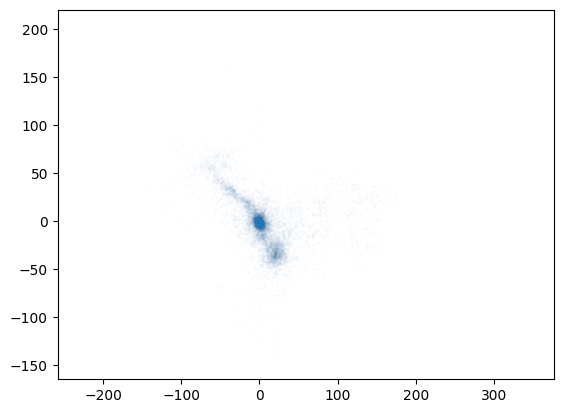

In [116]:
with h5py.File(saved_filename) as f:
    x = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    y = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    
    plt.scatter(x,y,s=1, alpha=0.01)
    plt.show()

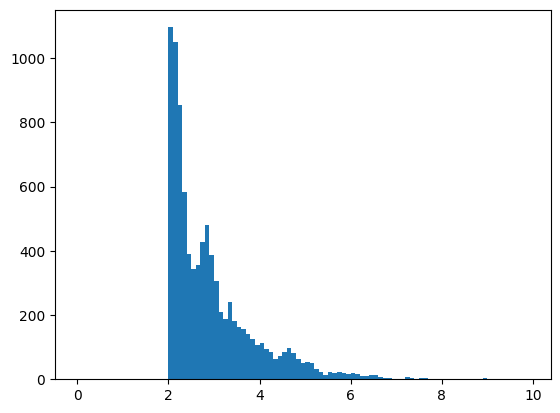

-322.49637 11.379515
1026
9012
[ 992.04720882 1161.68740806  984.99364647 ... 1006.09114285  930.89841112
  967.77563959] Myr


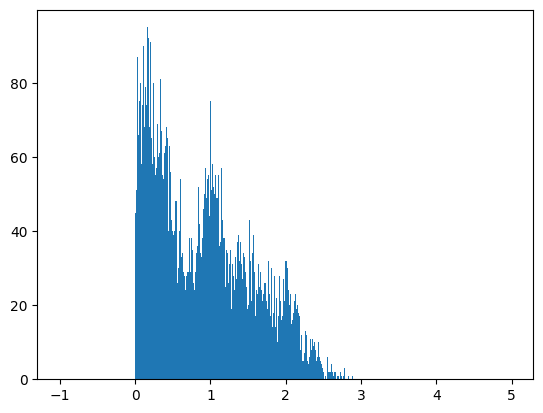

In [117]:

h = 0.7


from astropy.cosmology import Planck13 as cosmo
from unyt import Myr


with h5py.File(saved_filename) as f:

    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    plt.hist(formation_redshift, bins = np.arange(0., 10., 0.1))
    plt.show()

    print(np.min(formation_redshift), np.max(formation_redshift))
    print(np.sum(formation_redshift<0.0))
    print(np.sum(formation_redshift>2.0))

    # only select star particles that make sense
    s = formation_redshift>=2.0
    formation_redshift = formation_redshift[s]

    ages = (cosmo.age(z=2)-cosmo.age(formation_redshift)).to('Myr').value * Myr
    print(ages)

    plt.hist(ages.to('Gyr').value, bins = np.arange(-1., 5., 0.01))
    plt.show()



    



In [118]:

from unyt import kpc

# get other quantities, filtering for stupid stars
with h5py.File(saved_filename) as f:
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h
    metallicities = f['PartType4']['GFM_Metallicity'][s]
    coordinates = f['PartType4']['Coordinates'][s,:] / h * kpc 
    coordinates = coordinates - np.mean(coordinates, axis=0)
    
    print(coordinates.shape)
    print(np.min(coordinates, axis=0), np.max(coordinates, axis=0))
    print(np.median(coordinates, axis=0), np.mean(coordinates, axis=0))

(9012, 3)
[-334.16341858 -207.80390593 -194.25410031] kpc [490.67893633 292.85457621 285.72915862] kpc
[-5.18043867  0.58616104  0.42781933] kpc [-2.25234163e-11  7.08364369e-11  2.98627519e-11] kpc


In [119]:
from synthesizer.grid import Grid
from synthesizer.filters import FilterCollection as Filters
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel
from synthesizer.particle import Stars, Gas, Galaxy

Initialise stars object

In [120]:
stars = Stars(initial_masses=initial_masses,
            ages=ages,
            metallicities=metallicities,
            coordinates=coordinates, 
            )

galaxy = Galaxy(stars=stars)


/Users/sw376/Dropbox/Research/projects/synthesizer/src/synthesizer/particle/stars.py:212: RuntimeWarning: divide by zero encountered in log10
  self.log10metallicities = np.log10(self.metallicities)
/Users/sw376/Dropbox/Research/projects/synthesizer/src/synthesizer/particle/stars.py:212: RuntimeWarning: invalid value encountered in log10
  self.log10metallicities = np.log10(self.metallicities)


Calculate SED

In [121]:
grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False, new_lam=np.arange(1000., 16000., 1.))

----------
SUMMARY OF SED 
Number of wavelength points: 15000 
Wavelength range: [1000.00 Å,             15999.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             27.60 
log10(Bolometric luminosity/erg/s):[40.11509076 40.33501171 39.7903756  ... 40.30225333 39.70103634
 40.46969109]----------


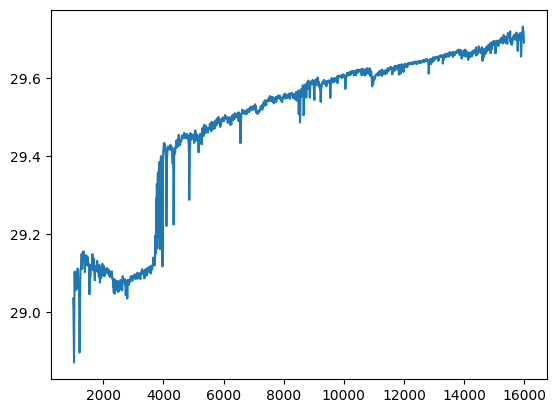

In [122]:
galaxy.stars.get_particle_spectra_incident(grid)

print(galaxy.stars.particle_spectra['incident'])

plt.plot(integrated_sed.lam, np.log10(integrated_sed.lnu))
plt.show()




In [123]:
from synthesizer.filters import UVJ

# Get a UVJ filter set
filters = UVJ(new_lam=grid.lam)

photometry = galaxy.stars.particle_spectra["incident"].get_photo_luminosities(filters)


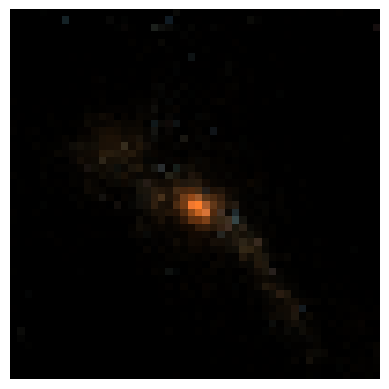

In [139]:

from unyt import kpc

fov = 200 * kpc

resolution = fov / 50

img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="incident",
    fov=fov,
)

# Make and plot an rgb image
img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
fig, ax, _ = img.plot_rgb_image(show=True)